### Import the Required Libraries

In [2]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

### Load the Data

In [3]:
def read_text(filename):
    file = open(filename, mode='rt' , encoding ='utf-8')
    
    text = file.read()
    file.close()
    return text

In [4]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("./fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [6]:
fra_eng = fra_eng[:50000,:]

### Text Cleaning / Prepocessing

In [7]:
# Remove punctuation
fra_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,1]]

fra_eng

array([['Go', 'Va ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go', 'Marche',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go', 'Bouge ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ...,
       ['Tom liked what he saw', 'Tom a aimé ce quil a vu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619279 (Aiji)'],
       ['Tom liked what he saw', 'Tom aima ce quil vit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619280 (Aiji)'],
       ['Tom likes skiing too', 'Tom aussi aime skier',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2869208 (CK) & #5591397 (Aiji)']],
      dtype='<U325')

In [8]:
for i in range(len(fra_eng)):
    fra_eng[i,0] = fra_eng[i,0].lower()
    fra_eng[i,1] = fra_eng[i,1].lower()

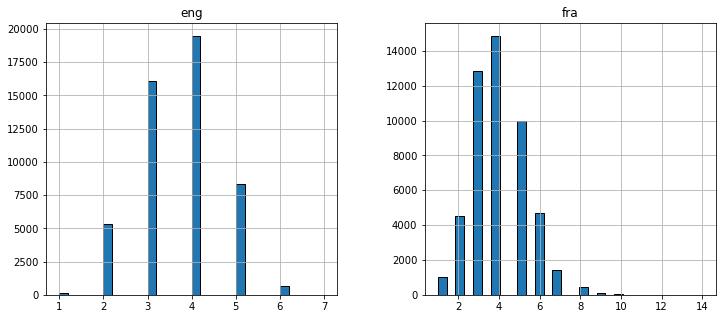

In [9]:
eng_l = []
fra_l = []

for i in fra_eng[:,0]:
      eng_l.append(len(i.split()))

for i in fra_eng[:,1]:
      fra_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fra':fra_l})

length_df.hist(bins = 30, edgecolor='k', figsize = (12,5))
plt.show()

In [10]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [11]:
eng_tokenizer = tokenization(fra_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6042


In [12]:
eng_tokenizer.index_word

{1: 'i',
 2: 'you',
 3: 'a',
 4: 'is',
 5: 'tom',
 6: 'it',
 7: 'the',
 8: 'to',
 9: 'im',
 10: 'he',
 11: 'this',
 12: 'me',
 13: 'that',
 14: 'are',
 15: 'do',
 16: 'youre',
 17: 'was',
 18: 'we',
 19: 'have',
 20: 'my',
 21: 'your',
 22: 'dont',
 23: 'not',
 24: 'were',
 25: 'its',
 26: 'they',
 27: 'go',
 28: 'be',
 29: 'did',
 30: 'can',
 31: 'all',
 32: 'she',
 33: 'like',
 34: 'no',
 35: 'in',
 36: 'what',
 37: 'very',
 38: 'of',
 39: 'here',
 40: 'want',
 41: 'how',
 42: 'ill',
 43: 'on',
 44: 'thats',
 45: 'get',
 46: 'cant',
 47: 'need',
 48: 'know',
 49: 'up',
 50: 'one',
 51: 'for',
 52: 'him',
 53: 'out',
 54: 'so',
 55: 'good',
 56: 'at',
 57: 'now',
 58: 'just',
 59: 'please',
 60: 'has',
 61: 'there',
 62: 'theyre',
 63: 'too',
 64: 'love',
 65: 'help',
 66: 'come',
 67: 'us',
 68: 'why',
 69: 'got',
 70: 'look',
 71: 'who',
 72: 'hes',
 73: 'lets',
 74: 'will',
 75: 'take',
 76: 'his',
 77: 'see',
 78: 'let',
 79: 'well',
 80: 'am',
 81: 'think',
 82: 'had',
 83: 'an',

In [13]:
fra_tokenizer = tokenization(fra_eng[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1

fra_length = 8
print('Deutch Vocabulary Size: %d' % fra_vocab_size)

Deutch Vocabulary Size: 13974


In [15]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

##### Model Architectue

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(fra_eng, test_size=0.2, random_state = 12)

In [17]:
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])   
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])   

testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [18]:
trainX[:5]

array([[ 1159,    25,   627,     0,     0,     0,     0,     0],
       [ 7114,   190,  1517,     0,     0,     0,     0,     0],
       [    1,     6,    36,   199,   286,     2,     0,     0],
       [10909,     0,     0,     0,     0,     0,     0,     0],
       [   43,    29,   101,  1574,     0,     0,     0,     0]])

### Define the Model

In [19]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    # sequential model for seq2seq network
    model = Sequential()
    # add embedding layer
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    # LSTM network
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [20]:
# model compilation
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)

In [21]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

### Fit the Model

In [22]:
filename = 'seq_2_seq_model'

In [23]:
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=128, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 3.2934
Epoch 1: val_loss improved from inf to 2.83209, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 213s 809ms/step - loss: 3.2934 - val_loss: 2.8321
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 2.7893
Epoch 2: val_loss improved from 2.83209 to 2.77747, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 194s 775ms/step - loss: 2.7893 - val_loss: 2.7775
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 2.7327
Epoch 3: val_loss improved from 2.77747 to 2.72237, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 194s 776ms/step - loss: 2.7327 - val_loss: 2.7224
Epoch 4/30
250/250 [==============================] - ETA: 0s - loss: 2.6656
Epoch 4: val_loss improved from 2.72237 to 2.67350, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 205s 820ms/step - loss: 2.6656 - val_loss: 2.6735
Epoch 5/30
250/250 [==============================] - ETA: 0s - loss: 2.6040
Epoch 5: val_loss improved from 2.67350 to 2.60457, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 306s 1s/step - loss: 2.6040 - val_loss: 2.6046
Epoch 6/30
250/250 [==============================] - ETA: 0s - loss: 2.5506
Epoch 6: val_loss improved from 2.60457 to 2.56355, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 325s 1s/step - loss: 2.5506 - val_loss: 2.5636
Epoch 7/30
250/250 [==============================] - ETA: 0s - loss: 2.4988
Epoch 7: val_loss improved from 2.56355 to 2.51005, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 367s 1s/step - loss: 2.4988 - val_loss: 2.5100
Epoch 8/30
250/250 [==============================] - ETA: 0s - loss: 2.4351
Epoch 8: val_loss improved from 2.51005 to 2.46542, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 316s 1s/step - loss: 2.4351 - val_loss: 2.4654
Epoch 9/30
250/250 [==============================] - ETA: 0s - loss: 2.3738
Epoch 9: val_loss improved from 2.46542 to 2.40279, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 366s 1s/step - loss: 2.3738 - val_loss: 2.4028
Epoch 10/30
250/250 [==============================] - ETA: 0s - loss: 2.3062
Epoch 10: val_loss improved from 2.40279 to 2.35154, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 809s 3s/step - loss: 2.3062 - val_loss: 2.3515
Epoch 11/30
250/250 [==============================] - ETA: 0s - loss: 2.2359
Epoch 11: val_loss improved from 2.35154 to 2.26327, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 754s 3s/step - loss: 2.2359 - val_loss: 2.2633
Epoch 12/30
250/250 [==============================] - ETA: 0s - loss: 2.1663
Epoch 12: val_loss improved from 2.26327 to 2.20652, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 749s 3s/step - loss: 2.1663 - val_loss: 2.2065
Epoch 13/30
250/250 [==============================] - ETA: 0s - loss: 2.0973
Epoch 13: val_loss improved from 2.20652 to 2.16819, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 805s 3s/step - loss: 2.0973 - val_loss: 2.1682
Epoch 14/30
250/250 [==============================] - ETA: 0s - loss: 2.0331
Epoch 14: val_loss improved from 2.16819 to 2.11054, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 783s 3s/step - loss: 2.0331 - val_loss: 2.1105
Epoch 15/30
250/250 [==============================] - ETA: 0s - loss: 1.9733
Epoch 15: val_loss improved from 2.11054 to 2.06986, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 1268s 5s/step - loss: 1.9733 - val_loss: 2.0699
Epoch 16/30
250/250 [==============================] - ETA: 0s - loss: 1.9153
Epoch 16: val_loss improved from 2.06986 to 2.00448, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 785s 3s/step - loss: 1.9153 - val_loss: 2.0045
Epoch 17/30
250/250 [==============================] - ETA: 0s - loss: 1.8587
Epoch 17: val_loss improved from 2.00448 to 1.97725, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 1095s 4s/step - loss: 1.8587 - val_loss: 1.9773
Epoch 18/30
250/250 [==============================] - ETA: 0s - loss: 1.8043
Epoch 18: val_loss improved from 1.97725 to 1.92089, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 1136s 5s/step - loss: 1.8043 - val_loss: 1.9209
Epoch 19/30
250/250 [==============================] - ETA: 0s - loss: 1.7517
Epoch 19: val_loss improved from 1.92089 to 1.89690, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 841s 3s/step - loss: 1.7517 - val_loss: 1.8969
Epoch 20/30
250/250 [==============================] - ETA: 0s - loss: 1.6989
Epoch 20: val_loss improved from 1.89690 to 1.86447, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 966s 4s/step - loss: 1.6989 - val_loss: 1.8645
Epoch 21/30
250/250 [==============================] - ETA: 0s - loss: 1.6494
Epoch 21: val_loss improved from 1.86447 to 1.82312, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 761s 3s/step - loss: 1.6494 - val_loss: 1.8231
Epoch 22/30
250/250 [==============================] - ETA: 0s - loss: 1.5994
Epoch 22: val_loss improved from 1.82312 to 1.79782, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 681s 3s/step - loss: 1.5994 - val_loss: 1.7978
Epoch 23/30
250/250 [==============================] - ETA: 0s - loss: 1.5531
Epoch 23: val_loss improved from 1.79782 to 1.76367, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 356s 1s/step - loss: 1.5531 - val_loss: 1.7637
Epoch 24/30
250/250 [==============================] - ETA: 0s - loss: 1.5071
Epoch 24: val_loss improved from 1.76367 to 1.73848, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 415s 2s/step - loss: 1.5071 - val_loss: 1.7385
Epoch 25/30
250/250 [==============================] - ETA: 0s - loss: 1.4643
Epoch 25: val_loss improved from 1.73848 to 1.70915, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 415s 2s/step - loss: 1.4643 - val_loss: 1.7092
Epoch 26/30
250/250 [==============================] - ETA: 0s - loss: 1.4218
Epoch 26: val_loss improved from 1.70915 to 1.68892, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 432s 2s/step - loss: 1.4218 - val_loss: 1.6889
Epoch 27/30
250/250 [==============================] - ETA: 0s - loss: 1.3810
Epoch 27: val_loss improved from 1.68892 to 1.67341, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 433s 2s/step - loss: 1.3810 - val_loss: 1.6734
Epoch 28/30
250/250 [==============================] - ETA: 0s - loss: 1.3394
Epoch 28: val_loss improved from 1.67341 to 1.64248, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 439s 2s/step - loss: 1.3394 - val_loss: 1.6425
Epoch 29/30
250/250 [==============================] - ETA: 0s - loss: 1.3010
Epoch 29: val_loss improved from 1.64248 to 1.61861, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 464s 2s/step - loss: 1.3010 - val_loss: 1.6186
Epoch 30/30
250/250 [==============================] - ETA: 0s - loss: 1.2617
Epoch 30: val_loss improved from 1.61861 to 1.59952, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


INFO:tensorflow:Assets written to: seq_2_seq_model\assets


250/250 [==============================] - 436s 2s/step - loss: 1.2617 - val_loss: 1.5995


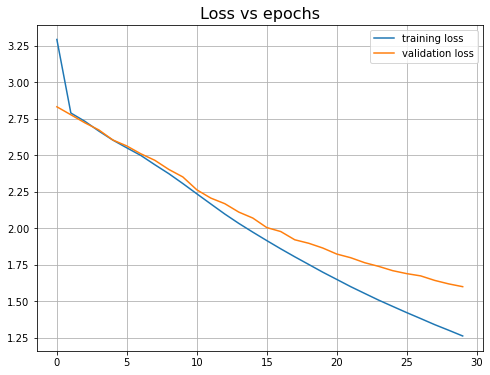

In [24]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.grid()
plt.title("Loss vs epochs",fontsize=16)
plt.show()

### Prediction on unseen data

In [25]:
model = load_model(filename)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 512)            7154688   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense (Dense)               (None, 8, 6042)           3099546   
                                                                 
Total params: 14,452,634
Trainable params: 14,452,634
Non-trainable params: 0
____________________________________________

In [27]:
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1]))[:1024,:],batch_size=128)

8/8 [==============================] - 7s 229ms/step


In [28]:
preds = preds.argmax(axis=2)

In [29]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [30]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))